In [ ]:
# Snake Game without Q-Learning

import numpy as np
import random


class BodyNode():
    def __init__(self, parent, x, y):
        self.parent = parent
        self.x = x
        self.y = y

    def setX(self, x):
        self.x = x

    def setY(self, y):
        self.y = y

    def setParent(self, parent):
        self.parent = parent

    def getPosition(self):
        return (self.x, self.y)
    
    def getIndex(self):
        return (self.y, self.x)


class Snake():
    def __init__(self, x, y):
        self.head = BodyNode(None, x, y)
        self.tail = self.head

    def moveBodyForwards(self):
        currentNode = self.tail
        while currentNode.parent != None:
            parentPosition = currentNode.parent.getPosition()
            currentNode.setX(parentPosition[0])
            currentNode.setY(parentPosition[1])
            currentNode = currentNode.parent

    def move(self, direction):
        (oldTailX, oldTailY) = self.tail.getPosition()
        self.moveBodyForwards()
        headPosition = self.head.getPosition()
        if direction == 0:
            self.head.setY(headPosition[1] - 1)
        elif direction == 1:
            self.head.setX(headPosition[0] + 1)
        elif direction == 2:
            self.head.setY(headPosition[1] + 1)
        elif direction == 3:
            self.head.setX(headPosition[0] - 1)
        return (oldTailX, oldTailY, *self.head.getPosition())

    def newHead(self, newX, newY):
        newHead = BodyNode(None, newX, newY)
        self.head.setParent(newHead)
        self.head = newHead
        
    def getHead(self):
        return self.head
    
    def getTail(self):
        return self.tail


class SnakeGame():
    def __init__(self, width, height):
        # arbitrary numbers to signify head, body, and food)
        # 0 for empty space
        self.headVal = 2
        self.bodyVal = 1
        self.foodVal = 7
        self.width = width
        self.height = height
        self.board = np.zeros([height, width], dtype=int)

        self.length = 1

        startX = width//2
        startY = height//2

        self.board[startX, startY] = self.headVal
        self.snake = Snake(startX, startY)
        self.spawnFood()
        self.calcState()
#        print(self.board)

    def spawnFood(self):
        # spawn food at location not occupied by snake
        emptyCells = []
        for index, value in np.ndenumerate(self.board):
            if value != self.bodyVal and value != self.headVal:
                emptyCells.append(index)
        self.foodIndex = random.choice(emptyCells)
        self.board[self.foodIndex] = self.foodVal

    def checkValid(self, direction):
        # check if move is blocked by wall
        newX, newY = self.potentialPosition(direction)
        if newX == -1 or newX == self.width:
            return False
        if newY == -1 or newY == self.height:
            return False
        # check if move is blocked by snake body
        if self.board[newY, newX] == self.bodyVal:
            return False
        return True

    def potentialPosition(self, direction):
        (newX, newY) = self.snake.getHead().getPosition()
        if direction == 0:
            newY -= 1
        elif direction == 1:
            newX += 1
        elif direction == 2:
            newY += 1
        elif direction == 3:
            newX -= 1
        return (newX, newY)

    def calcState(self):
        # state is as follows.
        # Is direction blocked by wall or snake?
        # Is food in this direction?
        # (top blocked, right blocked, down blocked, left blocked,
        # top food, right food, down food, left food)
        self.state = np.zeros(8, dtype=int)
        for i in range(4):
            self.state[i] = not self.checkValid(i)
        self.state[4:] = self.calcFoodDirection()

    def calcStateNum(self):
        # calculate an integer number for state
        # there will be 2^8 potential states but not all states are reachable
        stateNum = 0
        for i in range(8):
            stateNum += 2**i*self.state[i]
        return stateNum

    def calcFoodDirection(self):
        # food can be 1 or 2 directions eg. right and up
        # 0 is up, 1 is right, 2 is down, 3 is left
        foodDirections = np.zeros(4, dtype=int)
        dist = np.array(self.foodIndex) - np.array(self.snake.getHead().getIndex())
        if dist[0] < 0:
            # down
            foodDirections[0] = 1
        elif dist[0] > 0:
            # up
            foodDirections[2] = 1
        if dist[1] > 0:
            # right
            foodDirections[1] = 1
        elif dist[1] < 0:
            # left
            foodDirections[3] = 1
        return foodDirections

    def plottableBoard(self):
        #returns board formatted for animations
        board = np.zeros([self.width, self.height])
        currentNode = self.snake.tail
        count = 0
        while True:
            count += 1
            board[currentNode.getIndex()] = 0.2 + 0.8*count/self.length
            currentNode = currentNode.parent
            if currentNode == None:
                break
        board[self.foodIndex] = -1
        return board
        
        
    def display(self):
        for i in range(self.width+2):
            print('-', end='')
        for i in range(self.height):
            print('\n|', end='')
            for j in range(self.width):
                if self.board[i, j] == 0:
                    print(' ', end='')
                elif self.board[i, j] == self.headVal:
                    print('O', end='')
                elif self.board[i, j] == self.bodyVal:
                    print('X', end='')
                elif self.board[i, j] == self.foodVal:
                    print('*', end='')
            print('|', end='')
        print()
        for i in range(self.width+2):
            print('-', end='')
        print()
#        print(self.board)

    def makeMove(self, direction):
        gameOver = False
        if self.checkValid(direction):
            # set reward if moving in the right direction
            if self.calcFoodDirection()[direction] == 1:
                reward = 1
            else:
                reward = 0
            (headX, headY) = self.snake.getHead().getPosition()
            # set old head to body val
            self.board[headY, headX] = self.bodyVal

            # check if we got the fruit
            potX, potY = self.potentialPosition(direction)
            if self.board[potY, potX] == self.foodVal:
                # extend the snake
                self.snake.newHead(potX, potY)
                self.board[potY, potX] = self.headVal
                self.spawnFood()
                self.length += 1
                # if you want to give a higher reward for getting the fruit, uncomment below
                reward = 2
            else:
                # move the snake
                (oldTailX, oldTailY, newHeadX, newHeadY) = self.snake.move(direction)
                self.board[oldTailY, oldTailX] = 0
                self.board[newHeadY, newHeadX] = self.headVal
        else:
            reward = -2
            gameOver = True
        self.calcState()
        return (self.calcStateNum(), reward, gameOver, self.length)


if __name__ == "__main__":
    game = SnakeGame(8, 8)
    game.display()
    print("Score: 1")
    while True:
        direction = input("Input Direction (w,a,s,d or q to quit): ")
        if direction == 'w':
            new_state, reward, gameOver, score = game.makeMove(0)
        elif direction == 'a':
            new_state, reward, gameOver, score = game.makeMove(3)
        elif direction == 's':
            new_state, reward, gameOver, score = game.makeMove(2)
        elif direction == 'd':
            new_state, reward, gameOver, score = game.makeMove(1)
        elif direction == 'q':
            break
        if gameOver:
            print("Game Over, Score:", score)
            break
        else:
            game.display()
            print("Reward:", reward, "Score:", score)

----------
|        |
|        |
|        |
|        |
|    O   |
|        |
| *      |
|        |
----------
Score: 1


Training for 10001 games...
Episode 0 Average snake length without exploration: 1.0
Episode 100 Average snake length without exploration: 3.24
Episode 200 Average snake length without exploration: 2.16
Episode 300 Average snake length without exploration: 9.48
Episode 400 Average snake length without exploration: 15.08
Episode 500 Average snake length without exploration: 14.04
Episode 600 Average snake length without exploration: 13.48
Episode 700 Average snake length without exploration: 9.6
Episode 800 Average snake length without exploration: 8.44
Episode 900 Average snake length without exploration: 17.8
Episode 1000 Average snake length without exploration: 14.04
Episode 1100 Average snake length without exploration: 15.36
Episode 1200 Average snake length without exploration: 22.8
Episode 1300 Average snake length without exploration: 20.52
Episode 1400 Average snake length without exploration: 20.6
Episode 1500 Average snake length without exploration: 17.64
Episode 1600 Averag

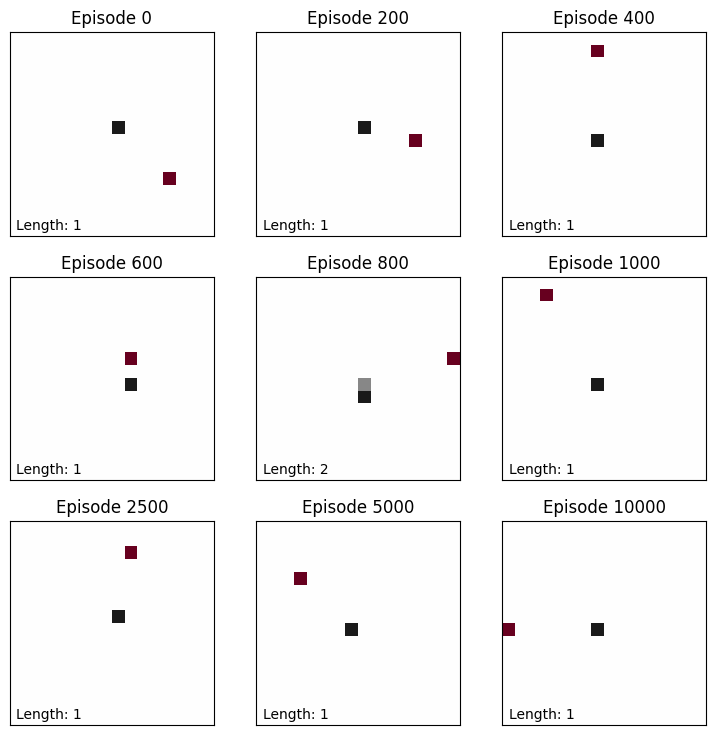

Saving to file


In [4]:
#Snake game using Q-Learning

import random
from Snake import SnakeGame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
#%%

def evaluateScore(Q, boardDim, numRuns, displayGame=False):
    # Run the game for a specified number of runs given a specific Q matrix
    cutoff = 100  # X moves without increasing score will cut off this game run
    scores = []
    for i in range(numRuns):
        game = SnakeGame(boardDim, boardDim)
        state = game.calcStateNum()
        score = 0
        oldScore = 0
        gameOver = False
        moveCounter = 0
        while not gameOver:
            possibleQs = Q[state, :]
            action = np.argmax(possibleQs)
            state, reward, gameOver, score = game.makeMove(action)
            if score == oldScore:
                moveCounter += 1
            else:
                oldScore = score
                moveCounter = 0
            if moveCounter >= cutoff:
                # stuck going back and forth
                break
        scores.append(score)
    return np.average(scores), scores


# %%
boardDim = 16  # size of the baord

# state is as follows.
# Is direction blocked by wall or snake?
# Is food in this direction? can either be one or two directions eg (food is left) or (food is left and up)
# state =  (top blocked, right blocked, down blocked, left blocked, up food, right food, down food, left food)
# 8 boolean values. Not all states are reachable (eg states with food directions that don't make sense)
numStates = 2**8
numActions = 4  # 4 directions that the snake can move
Q = np.zeros((numStates, numActions))

# lr = 0.9 #learning rate. not used in this Q learning equation
gamma = 0.8  # discount rate
epsilon = 0.2  # exploration rate in training games
numEpisodes = 10001  # number of games to train for

Qs = np.zeros([numEpisodes, numStates, numActions])
bestLength = 0
print("Training for", numEpisodes, "games...")
for episode in range(numEpisodes):
    #    print("New Game")
    game = SnakeGame(boardDim, boardDim)
    state = game.calcStateNum()
    gameOver = False
    score = 0
    while not gameOver:
        if random.uniform(0, 1) < epsilon:
            action = random.randint(0, 3)
        else:
            possibleQs = Q[state, :]
            action = np.argmax(possibleQs)
        new_state, reward, gameOver, score = game.makeMove(action)

        # http: // mnemstudio.org/path-finding-q-learning-tutorial.htm
        Q[state, action] = reward + gamma * np.max(Q[new_state, :])

        # https://towardsdatascience.com/simple-reinforcement-learning-q-learning-fcddc4b6fe56
        # Q[state, action] = Q[state, action] + lr * (reward + gamma * np.max(Q[new_state, :]) - Q[state, action])
        state = new_state
    Qs[episode, :, :] = np.copy(Q)
    if episode % 100 == 0:
        averageLength, lengths = evaluateScore(Q, boardDim, 25)
        if averageLength > bestLength:
            bestLength = averageLength
            bestQ = np.copy(Q)
        print("Episode", episode, "Average snake length without exploration:", averageLength)
        
#%%
#Animate games at different episodes
print("Generating data for animation...")
#plotEpisodes = [0, 200, 300, 400, 500, 600, 700, 800, 900]
plotEpisodes = [0, 200, 400, 600, 800, 1000, 2500, 5000, 10000]
fig, axes = plt.subplots(3, 3, figsize=(9,9))

axList = []
ims = []
dataArrays = []
scores = []
labels = []

for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ax.set_title("Episode " + str(plotEpisodes[i*len(row) + j]))
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
        axList.append(ax)
        ims.append(ax.imshow(np.zeros([boardDim, boardDim]), vmin=-1, vmax=1, cmap='RdGy'))
        labels.append(ax.text(0,15, "Length: 0", bbox={'facecolor':'w', 'alpha':0.75, 'pad':1, 'edgecolor':'white'}))
        dataArrays.append(list())
        scores.append(list())
        
stopAnimation = False
maxFrames = 1000
cutoff = 100
numGames = 10
for k in range(numGames):
    games = []
    states = []
    gameOvers = []
    moveCounters = []
    oldScores = []
    for l in range(len(plotEpisodes)):
        game = SnakeGame(boardDim, boardDim)
        games.append(game)
        states.append(game.calcStateNum())
        gameOvers.append(False)
        moveCounters.append(0)
        oldScores.append(0)
    for j in range(maxFrames):
        for i in range(len(plotEpisodes)):
            possibleQs = Qs[plotEpisodes[i], :, :][states[i], :]
            action = np.argmax(possibleQs)
            states[i], reward, gameOver, score = games[i].makeMove(action)
            if gameOver:
                gameOvers[i] = True
            dataArrays[i].append(games[i].plottableBoard())
            scores[i].append(score)
            if score == oldScores[i]:
                moveCounters[i] += 1
            else:
                oldScores[i] = score
                moveCounters[i] = 0
            if moveCounters[i] >= cutoff:
                # stuck going back and forth
                gameOvers[i] = True
        if not any(gameOver == False for gameOver in gameOvers):
            print("Game", k, "finished, total moves:", len(dataArrays[0]))
            break

def animate(frameNum):
    for i, im in enumerate(ims):
        labels[i].set_text("Length: " + str(scores[i][frameNum]))
        ims[i].set_data(dataArrays[i][frameNum])
    return ims+labels
print("Animating snakes at different episodes...")

numFrames = len(dataArrays[0])
ani = animation.FuncAnimation(fig, func=animate, frames=numFrames,blit=True, interval=75, repeat=False, )
plt.show(block=False)
#%%
##uncomment below if you want to output to a video file
print("Saving to file")

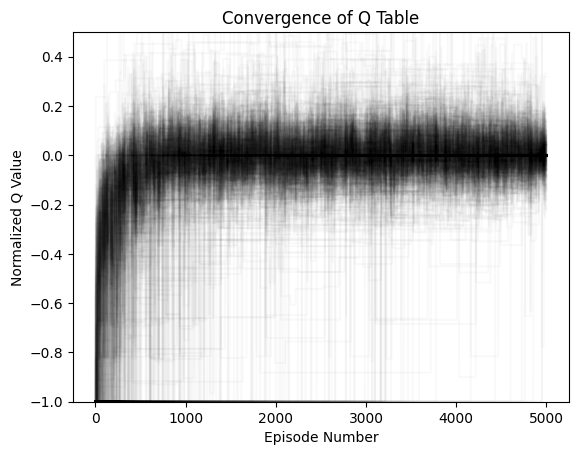

In [5]:
##Generates convergence graph after QLearning script has run
usedQs = []
for index, val in np.ndenumerate(Qs[0,:,:]):
    qLine = Qs[:, index[0], index[1]][:5000]
    if any([item != 0 for item in qLine]) and qLine[-1] != 0:
        usedQs.append(np.copy(qLine))
        
usedQs = np.abs(usedQs)
y = []
finalVals = []
for i in range(len(usedQs)):
    #y.append((fullQs[j][hasSomethingList[i][0],hasSomethingList[i][1]] - maxVals[i])/maxVals[i])
    finalVal = np.mean(usedQs[i][-100:])
    finalVals.append(finalVal)
    y = (usedQs[i]-finalVal) / finalVal
    plt.plot(y,color="black",alpha=0.025)
plt.ylim(-1,0.5)
plt.title("Convergence of Q Table")
plt.ylabel("Normalized Q Value")
plt.xlabel("Episode Number")
plt.savefig("ConvergenceGraph.png", dpi=300)
plt.show()

In [6]:
ani.save('AnimatedSnake.gif', writer='pillow', fps=15)
print("Done")

Done
